# Projeto de Redes Neurais Hipercomplexas


## Importando os Pacotes Necessários

In [1]:
!pip install progressbar2
!pip install scipy
!pip install netcdf4

# Reinstalar as bibliotecas na ordem correta
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow.keras as kr
from tensorflow.keras import layers, activations, initializers, Input
from sklearn import preprocessing #Normalização
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Model, Sequential
from tqdm import tqdm

from tensorflow.python.framework import tensor_shape
import xarray as xr
import progressbar
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
# Montar o Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Definindo uma Camada Densa em uma álgebra arbitrária:

In [3]:
class V_Dense(tf.keras.layers.Layer):
    def __init__(self, units=32, use_bias=True, activation=None,
                 algebra = np.stack([np.array([[1.0,0.0],[0.0,-1.0]]), np.array([[0.0,1.0],[1.0,0.0]])], axis=-1), **kwargs):
        super(V_Dense, self).__init__(**kwargs)

        self.algebra = np.float32(algebra)
        self.algdim = self.algebra.shape[2]
        self.units = units
        self.use_bias = use_bias
        self.activation = tf.keras.activations.get(activation)  # Support specifying activation function

    def get_config(self):
        config = super().get_config()
        config.update({
            "units": self.units,
            "use_bias": self.use_bias,
            "activation": tf.keras.activations.serialize(self.activation),
            "algebra": self.algebra.tolist(),  # Converting numpy array to list for JSON serialization
        })
        return config

    @classmethod
    def from_config(cls, config):
        config['algebra'] = np.array(config['algebra'], dtype=np.float32)
        return cls(**config)

    def build(self, input_shape):
        assert input_shape[-1] % self.algdim == 0
        input_dim = input_shape[-1] // self.algdim

        # Real-part of the weights
        self.W = self.add_weight(
            shape=(input_dim, self.units, self.algdim),
            initializer="glorot_normal",
            trainable=True,
        )

        if self.use_bias:
            # Bias complex-valued
            self.b = self.add_weight(
                shape=(self.algdim * self.units,),
                initializer="zeros",
                trainable=True,
            )

    def call(self, inputs):
        W = tf.reduce_sum(
            [tf.experimental.numpy.kron(self.algebra[:, :, i], self.W[:, :, i]) for i in range(self.algdim)],
            axis=0
        )

        outputs = tf.matmul(inputs, W)

        if self.use_bias:
            outputs = tf.nn.bias_add(outputs, self.b)

        if self.activation is not None:
            outputs = self.activation(outputs)

        return outputs

## Definindo a Classe dos Dados:


In [4]:
class Comprev():
    def __init__(self):
          self.var = "" #name of variable
          self.netcdf = None  #Arquivo de entrada para treinar a rede
          self.listy = None
          self.step = 0 #Passo que separam a latitude e longitude
          self.out = None #arquivo de saída da previsão da rede

    def PreProcessPoint(self,lat:float, lon:float, time):
      """ Irá receber um ponto lat, lon e tempo e irá retornar um vetor com os pontos do quadrilátero no formato
      np.array([(v1, lat1, lon1, time)
      (v1, b1, lat2, lon2, time)
      (v1, lat3, lon3, time)
      (v1, lat4, lon4, time)])

      ou
      0 se for ponto no final ou der erro
      """

      self.step = t = abs(round( a.netcdf.latitude.values[0] - a.netcdf.latitude.values[1], 2)) #Variação da lat lon
      vector = np.array([np.zeros(4),
                        np.zeros(4),
                        np.zeros(4),
                        np.zeros(4)])

      vector[0] = np.array([ self.netcdf.sel(latitude=lat, longitude=lon, time=time, method='nearest')[self.var].values,
                            lat, lon, pd.Timestamp(time).month])
      vector[1] = np.array([ self.netcdf.sel(latitude=lat, longitude=lon+2*t, time=time, method='nearest')[self.var].values,
                            lat, lon+t, pd.Timestamp(time).month])
      vector[2] = np.array([ self.netcdf.sel(latitude=lat+2*t, longitude=lon, time=time, method='nearest')[self.var].values,
                            lat+t, lon, pd.Timestamp(time).month])
      vector[3] = np.array([ self.netcdf.sel(latitude=lat+2*t, longitude=lon+2*t, time=time, method='nearest')[self.var].values,
                            lat+t, lon+t, pd.Timestamp(time).month])
      y = np.array([
          self.netcdf.sel(latitude=lat, longitude=lon+t, time=time, method='nearest')[self.var].values,
          self.netcdf.sel(latitude=lat+t, longitude=lon, time=time, method='nearest')[self.var].values,
          self.netcdf.sel(latitude=lat+t, longitude=lon+t, time=time, method='nearest')[self.var].values,
          self.netcdf.sel(latitude=lat+t, longitude=lon+2*t, time=time, method='nearest')[self.var].values,
          self.netcdf.sel(latitude=lat+2*t, longitude=lon+t, time=time, method='nearest')[self.var].values
      ])
      return (vector, y)

    def PreProcessDataframe(self, timevar=None):
      """ Considering the dataframe like
      array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

       we pre process all point 4 to for
      """

      if timevar is None:
        size = len(self.netcdf.latitude.values[:-1])*len(self.netcdf.longitude.values[:-1])*len(self.netcdf.time.values[:60])
        x = np.zeros((size,4,4))
        y = np.zeros((size, 5))
        t=0
        t1=0
        ylist = np.zeros((5*size, 4))
        for time in tqdm(self.netcdf.time.values[:60]):
          for lat in self.netcdf.latitude.values[:-1]:
            for lon in self.netcdf.longitude.values[:-1]:
              x[t], y[t] = self.PreProcessPoint(lat=lat, lon=lon,time=time)
              for i in y[t]:
                ylist[t1] = np.array([lat, lon+self.step, time, i])
                t1+=1
              t=t+1
        df = pd.DataFrame(ylist)
        df.columns = ["latitude", "longitude", "time", "pr"]
        self.listy = df
      else:
        size = len(self.netcdf.latitude.values[:-1])*len(self.netcdf.longitude.values[:-1])
        x = np.zeros((size, 4,4))
        y = np.zeros((size, 5))
        t=0
        t1=0
        ylist = np.zeros((5*size, 4))
        bar = progressbar.ProgressBar(size)
        for lat in self.netcdf.latitude.values[:-1]:
          for lon in self.netcdf.longitude.values[:-1]:
            x[t], y[t] = self.PreProcessPoint(lat=lat, lon=lon,time=timevar)
            for i in y[t]:
              ylist[t1] = np.array([lat, lon+self.step, timevar, i])
              t1+=1
            bar.update(t)
            t=t+1
        df = pd.DataFrame(ylist)
        df.columns = ["latitude", "longitude", "time", "pr"]
        self.listy = df

      x = x.reshape(x.shape[0],4*4)
      return (x, y)

    def PreProcessToNetcdf(self):
      pass

    def PlotNetcdf(self):
        t = self.netcdf.isel(time=1)
        t[self.var].plot()

    def ReadNetcdf(self, path:str, var:str):

        self.netcdf = xr.open_dataset(path)
        self.var = var
    def ReadMFNetcdf(self, path:str, var:str):
        self.netcdf = xr.open_mfdataset(path)
        self.var = var

    def interpolate(self):
        return  dados.interp(x="latitude", y="longitude")


## Carregando e pré-processando os Dados

In [5]:
a = Comprev()


In [6]:
a.ReadNetcdf("/content/gdrive/MyDrive/Trabalho RedesH/pr_19610101_19801231.nc", var="pr")
print(a.netcdf)#/content/gdrive/MyDrive/Trabalho RedesH/pr_19610101_19801231.nc
t = 6 # quantidade de pontos acima e abaixo
lat_median = -22.85 #latitude central
lon_median = -47.05 #longitude central
a.netcdf = a.netcdf.sel(latitude = np.arange(lat_median-0.1*t, lat_median+0.1*t, 0.1), longitude = np.arange(lon_median-0.1*t, lon_median+0.1*t, 0.1), method="nearest")
#Xtr, Ytr = a.PreProcessDataframe()

#Carregando os Dados de Treino (Já salvos em arquivos .npy)
Xtr = np.load('/content/gdrive/MyDrive/Trabalho RedesH/Pr_VetoresDeTreino/Xtr.npy')
Ytr = np.load('/content/gdrive/MyDrive/Trabalho RedesH/Pr_VetoresDeTreino/Ytr.npy')


<xarray.Dataset>
Dimensions:    (time: 7305, latitude: 393, longitude: 391)
Coordinates:
  * time       (time) datetime64[ns] 1961-01-01 1961-01-02 ... 1980-12-31
  * latitude   (latitude) float32 -33.85 -33.75 -33.65 -33.55 ... 5.15 5.25 5.35
  * longitude  (longitude) float32 -73.85 -73.75 -73.65 ... -35.05 -34.95 -34.85
Data variables:
    pr         (time, latitude, longitude) float32 ...
Attributes:
    title:                Brazilian Daily Weather Gridded Data (1961-2020)
    institution:          Federal University of Espirito Santo; University of...
    institution_id:       UFES; UTEXAS
    history:              Created Mon Jun 12 15:02:05 2023
    temporal_resolution:  24-hourly
    contact:              alexandre.xavier@ufes.br; careyking@energy.utexas.e...
    main_code:            gerando_ncfiles_pr_8bits.py
    update_information:   https://sites.google.com/site/alexandrecandidoxavie...
    main_paper:           Xavier, A.C., Scanlon, B.R., King, C.W. and Alves, ...
    I

In [7]:
Xtr = np.nan_to_num(Xtr, nan=0)
Ytr = np.nan_to_num(Ytr, nan=0)

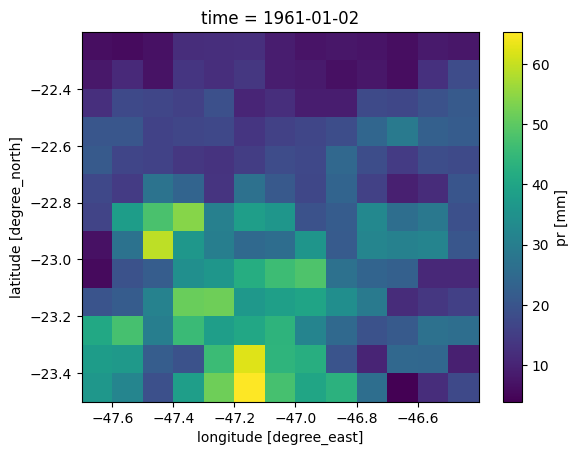

In [8]:
a.PlotNetcdf()

## Definindo a Arquitetura da Rede e Treinando o Modelo

### Defindo a álgebra dos Quatérnios

In [9]:
quaternions = np.stack([np.array([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,-1]]),
                        np.array([[0,1,0,0],[1,0,0,0],[0,0,0,1],[0,0,-1,0]]),
                        np.array([[0,0,1,0],[0,0,0,-1],[1,0,0,0],[0,1,0,0]]),
                        np.array([[0,0,0,1],[0,0,1,0],[0,-1,0,0],[1,0,0,0]])
                        ],axis=2)

### Arquitetura da rede

In [10]:
#Mlp_Q = Sequential([
#    kr.Input(shape=(16,)),#Representa uma entrada como um vetor de 4 números quaternions
#    V_Dense(algebra=quaternions,units=20,activation='relu'),
#    V_Dense(algebra=quaternions,units=300,activation='relu'),
#    V_Dense(algebra=quaternions,units=400,activation='relu'),
#    V_Dense(algebra=quaternions,units=366,activation='relu'),
#    Dense(units=5,activation=None,use_bias=False)])
Mlp_Q = tf.keras.models.load_model('/content/gdrive/MyDrive/Trabalho RedesH/Modelos/model_previsao_t6_400epochs.keras', custom_objects={'V_Dense': V_Dense})

In [11]:
Mlp_Q.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 v__dense_28 (V_Dense)       (None, 80)                400       
                                                                 
 v__dense_29 (V_Dense)       (None, 1200)              25200     
                                                                 
 v__dense_30 (V_Dense)       (None, 1600)              481600    
                                                                 
 v__dense_31 (V_Dense)       (None, 1464)              587064    
                                                                 
 dense_7 (Dense)             (None, 5)                 7320      
                                                                 
Total params: 1101584 (4.20 MB)
Trainable params: 1101584 (4.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Compilando a Rede

In [12]:
Xtr[:1]

array([[ 13.32132939, -23.45000076, -47.65000153,   1.        ,
         16.60359508, -23.45000076, -47.55000305,   1.        ,
         11.32312998, -23.35000038, -47.65000153,   1.        ,
         12.41492965, -23.35000038, -47.55000305,   1.        ]])

In [13]:
print(Xtr.shape)

(144000, 16)


In [14]:
Mlp_Q.compile(loss='mse',optimizer='adam', metrics=[kr.metrics.RootMeanSquaredError()])

Mlp_Q.predict(Xtr[:1])

# Normalizando os Dados
scalerX = preprocessing.StandardScaler().fit(Xtr)
scalerY = preprocessing.StandardScaler().fit(Ytr)

# Treinando a rede
#c_hist = Mlp_Q.fit(scalerX.transform(Xtr),scalerY.transform(Ytr),epochs=100)


1/1 [==============================] - 4s 4s/step


In [15]:
#Mlp_Q.save('/content/gdrive/MyDrive/Trabalho RedesH/Modelos/model_previsao_t6_400epochs.keras')

## Carregando os Dados de Teste

In [16]:
a.ReadNetcdf("/content/gdrive/MyDrive/Trabalho RedesH/pr_20010101_20200731_BR-DWGD_UFES_UTEXAS_v_3.2.2.nc", var="pr")
t = 6 # quantidade de pontos acima e abaixo
lat_median = -22.85 #latitude central
lon_median = -47.05 #longitude central
a.netcdf = a.netcdf.sel(latitude = np.arange(lat_median-0.1*t, lat_median+0.1*t, 0.1),
                        longitude = np.arange(lon_median-0.1*t, lon_median+0.1*t, 0.1),
                        method="nearest")
Xtest, Ytest = a.PreProcessDataframe(timevar=a.netcdf.time.values[0])

\ |              #                                  | 143 Elapsed Time: 0:00:18

Rodando a rede para os dados de teste

In [17]:
k = scalerY.inverse_transform(Mlp_Q.predict(scalerX.transform(Xtest)))

5/5 [==============================] - 1s 174ms/step


In [18]:
k  = np.concatenate(k.reshape(k.size, 1))
k.shape

(720,)

Plotando o gráfico do módulo do Erro cometido pela rede neural considerando os dados de teste

      latitude  longitude          time         pr
0   -23.450001 -47.550003  9.783072e+17  11.323135
1   -23.450001 -47.550003  9.783072e+17   3.831604
2   -23.450001 -47.550003  9.783072e+17   4.257339
3   -23.450001 -47.550003  9.783072e+17   3.069397
4   -23.450001 -47.550003  9.783072e+17   4.374069
..         ...        ...           ...        ...
715 -22.350000 -46.450001  9.783072e+17   4.264206
716 -22.350000 -46.450001  9.783072e+17   1.730392
717 -22.350000 -46.450001  9.783072e+17   2.767273
718 -22.350000 -46.450001  9.783072e+17   2.767273
719 -22.350000 -46.450001  9.783072e+17   2.767273

[720 rows x 4 columns]


Text(0, 0.5, 'Latitude')

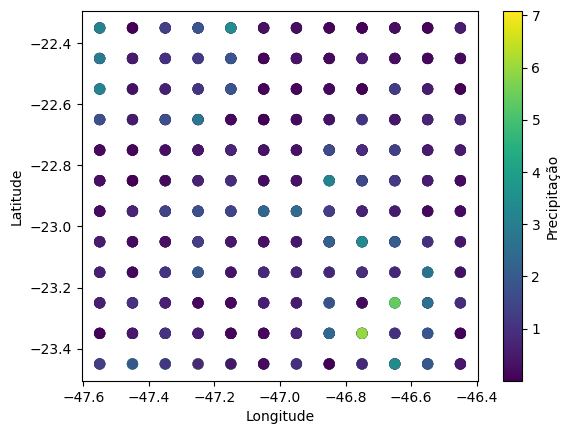

In [19]:
df =  a.listy
print(df)
plt.scatter(df.longitude, df.latitude, c=abs(df.pr-k), cmap='viridis', s=50)
plt.colorbar(label='Precipitação')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

## Calculando o erro médio em cada coordenada e Obtendo a pior malha

In [20]:
Xtest, Ytest = a.PreProcessDataframe(timevar=a.netcdf.time.values[0])
k = scalerY.inverse_transform(Mlp_Q.predict(scalerX.transform(Xtest)))
df =  a.listy
k  = np.concatenate(k.reshape(k.size, 1))
out = np.zeros(k.size)
n=40
PiorValor = 0
PiorMalha = np.zeros(k.size)
for k in range(n):
  Xtest, Ytest = a.PreProcessDataframe(timevar=a.netcdf.time.values[np.random.randint(n)])
  k = scalerY.inverse_transform(Mlp_Q.predict(scalerX.transform(Xtest)))
  df =  a.listy
  k  = np.concatenate(k.reshape(k.size, 1))
  out += df.pr-k
  if PiorValor < np.absolute(df.pr-k).max():
    PiorValor = np.absolute(df.pr-k).max()
    PiorMalha = df.pr-k


\ |                             #                   | 142 Elapsed Time: 0:00:12

5/5 [==============================] - 1s 128ms/step


\ |                                   #             | 142 Elapsed Time: 0:00:13

5/5 [==============================] - 1s 107ms/step


/ |                                          #      | 140 Elapsed Time: 0:00:04

5/5 [==============================] - 0s 70ms/step


/ |                                                #| 142 Elapsed Time: 0:00:04

5/5 [==============================] - 0s 67ms/step


- |                                 #               | 140 Elapsed Time: 0:00:03

5/5 [==============================] - 0s 60ms/step


\ |                                  #              | 143 Elapsed Time: 0:00:03

5/5 [==============================] - 0s 65ms/step


/ |                                            #    | 141 Elapsed Time: 0:00:04

5/5 [==============================] - 0s 91ms/step


/ |                                     #           | 139 Elapsed Time: 0:00:03

5/5 [==============================] - 0s 59ms/step


- |                                #                | 139 Elapsed Time: 0:00:03

5/5 [==============================] - 0s 60ms/step


/ |                                    #            | 141 Elapsed Time: 0:00:03

5/5 [==============================] - 0s 95ms/step


| |                                           #     | 141 Elapsed Time: 0:00:04

5/5 [==============================] - 0s 60ms/step


\ |                                  #              | 142 Elapsed Time: 0:00:03

5/5 [==============================] - 0s 62ms/step


- |                                 #               | 140 Elapsed Time: 0:00:03

5/5 [==============================] - 0s 71ms/step


| |                                             #   | 140 Elapsed Time: 0:00:05

5/5 [==============================] - 0s 63ms/step


- |                                 #               | 139 Elapsed Time: 0:00:03

5/5 [==============================] - 0s 65ms/step


- |                                 #               | 140 Elapsed Time: 0:00:03

5/5 [==============================] - 0s 63ms/step


/ |                                              #  | 142 Elapsed Time: 0:00:05

5/5 [==============================] - 0s 62ms/step


- |                                 #               | 139 Elapsed Time: 0:00:03

5/5 [==============================] - 0s 62ms/step


- |                                 #               | 141 Elapsed Time: 0:00:03

5/5 [==============================] - 0s 72ms/step


\ |                                     #           | 141 Elapsed Time: 0:00:06

5/5 [==============================] - 0s 63ms/step


- |                                 #               | 140 Elapsed Time: 0:00:03

5/5 [==============================] - 0s 69ms/step


\ |                                 #               | 143 Elapsed Time: 0:00:03

5/5 [==============================] - 0s 71ms/step


\ |                                           #     | 143 Elapsed Time: 0:00:04

5/5 [==============================] - 0s 93ms/step


\ |                                      #          | 142 Elapsed Time: 0:00:03

5/5 [==============================] - 0s 71ms/step


| |                                         #       | 141 Elapsed Time: 0:00:04

5/5 [==============================] - 0s 64ms/step


/ |                                             #   | 141 Elapsed Time: 0:00:04

5/5 [==============================] - 0s 86ms/step


\ |                                      #          | 142 Elapsed Time: 0:00:03

5/5 [==============================] - 0s 63ms/step


- |                                 #               | 142 Elapsed Time: 0:00:03

5/5 [==============================] - 0s 63ms/step


/ |                                   #             | 143 Elapsed Time: 0:00:03

5/5 [==============================] - 0s 94ms/step


/ |                                             #   | 143 Elapsed Time: 0:00:04

5/5 [==============================] - 0s 61ms/step


- |                                #                | 141 Elapsed Time: 0:00:03

5/5 [==============================] - 0s 64ms/step


- |                                #                | 142 Elapsed Time: 0:00:03

5/5 [==============================] - 0s 62ms/step


\ |                                               # | 143 Elapsed Time: 0:00:04

5/5 [==============================] - 0s 95ms/step


- |                                #                | 141 Elapsed Time: 0:00:03

5/5 [==============================] - 0s 65ms/step


- |                                 #               | 143 Elapsed Time: 0:00:03

5/5 [==============================] - 0s 64ms/step


\ |                                            #    | 142 Elapsed Time: 0:00:04

5/5 [==============================] - 1s 108ms/step


- |                                          #      | 143 Elapsed Time: 0:00:05

5/5 [==============================] - 0s 69ms/step


- |                                 #               | 143 Elapsed Time: 0:00:03

5/5 [==============================] - 0s 62ms/step


- |                                #                | 141 Elapsed Time: 0:00:03

5/5 [==============================] - 0s 62ms/step


| |                                             #   | 143 Elapsed Time: 0:00:04

5/5 [==============================] - 1s 97ms/step


- |                                #                | 139 Elapsed Time: 0:00:03

5/5 [==============================] - 0s 69ms/step


Plotando o gráfico do Erro Médio

      latitude  longitude          time            pr
0   -23.450001 -47.550003  9.802944e+17  2.204193e+00
1   -23.450001 -47.550003  9.802944e+17 -2.842171e-14
2   -23.450001 -47.550003  9.802944e+17 -2.842171e-14
3   -23.450001 -47.550003  9.802944e+17  1.985840e+01
4   -23.450001 -47.550003  9.802944e+17 -2.842171e-14
..         ...        ...           ...           ...
715 -22.350000 -46.450001  9.802944e+17  7.690735e-01
716 -22.350000 -46.450001  9.802944e+17  5.596329e+00
717 -22.350000 -46.450001  9.802944e+17  3.412735e+00
718 -22.350000 -46.450001  9.802944e+17  3.412735e+00
719 -22.350000 -46.450001  9.802944e+17  3.412735e+00

[720 rows x 4 columns]


Text(0, 0.5, 'Latitude')

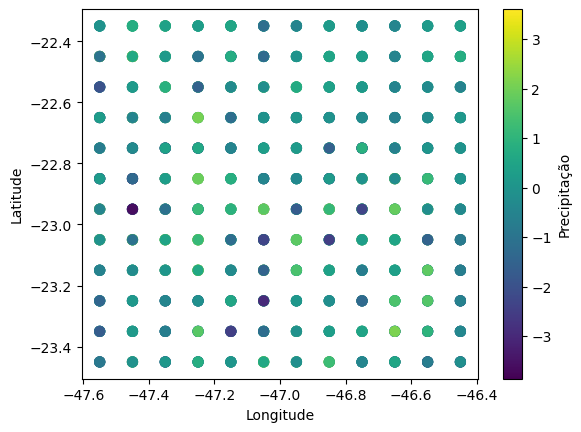

In [21]:
print(df)
plt.scatter(df.longitude, df.latitude, c=out/n, cmap='viridis', s=50)
plt.colorbar(label='Precipitação')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

Plotando o gráfico da pior Malha

41.25193405151367


Text(0, 0.5, 'Latitude')

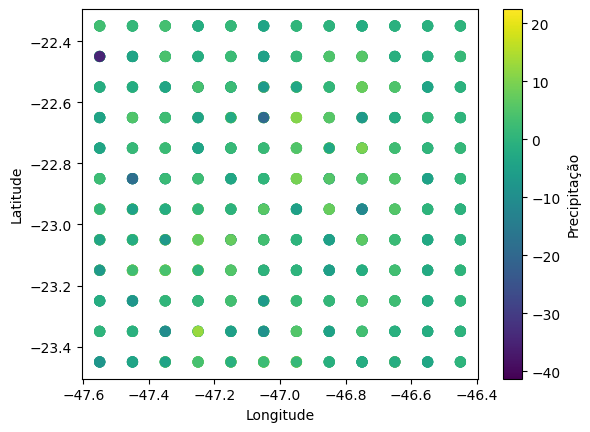

In [22]:
print(PiorValor)
plt.scatter(df.longitude, df.latitude, c=PiorMalha, cmap='viridis', s=50)
plt.colorbar(label='Precipitação')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

## Salvando e Plotando os Historys

Salvando os Historys

In [23]:
import numpy as np
import json
# Definindo e treinando o modelo conforme o exemplo anterior

# Salvando o histórico de treinamento em um arquivo JSON
#with open('/content/gdrive/MyDrive/Trabalho RedesH/Historys/training_history_400_it.json', 'w') as f:
   ##json.dump(c_hist.history, f)

Carregando e Plotando o History necessário

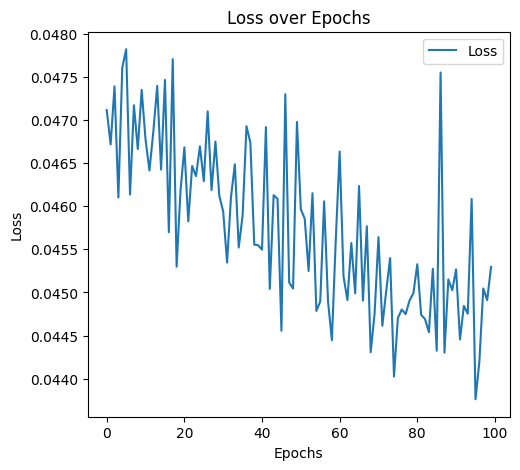

In [24]:
# Carregar o histórico de treinamento a partir do arquivo JSON
with open('/content/gdrive/MyDrive/Trabalho RedesH/Historys/training_history_400_it.json', 'r') as f:
    history = json.load(f)

# Plotando a perda (loss)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plotando a precisão (accuracy) se disponível
if 'accuracy' in history:
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

plt.show()

Salvando o Modelo

In [25]:
####Mlp_Q.save('/content/gdrive/MyDrive/Trabalho RedesH/Modelos/model_previsao_t6_100epochs.keras')